# **PLAYER SIMILARITY APPLICATION**

The following code serves as a recommender system for football players in La Liga through cosine_similarity.
-  **input** : name of a player (FBref format), position to compare to (FW, MF or DF)
-  **outputs** : a plottable table with the n (default 5) more similar players to the one given. The stats in which the algorithm bases the similarity calculation are also present. Similarity scores [0-1] ressemblance of the player given as input to each of the players calculated.

*Constraints* (At least 3 matches played to be eligible for comparison)
*Update (20/02/24)* Now the comparison is possible with players from the 5 Big Leagues. Still Checking bugs and quality of comparisons.

In [ ]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os

from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats.mstats import winsorize

!pip install plottable
from plottable import ColumnDefinition, Table
from plottable.cmap import normed_cmap
from plottable.plots import image

Jornada = 26

## *Functions*

Some blocks built to run the program.
 - check position
 - build test_df
 - ml algorithm (cosine similarity)
 - plottable table build



In [ ]:
def check_pos(player_name):
  try:
      std_df = pd.read_csv(f'/content/drive/MyDrive/FootballAnalytics/LaLiga/Jornada{Jornada}/PlayerStats/LaLiga_Player_Standard_Stats_Jornada{Jornada}.csv')
      player_row = std_df[std_df['player'] == player_name]
      if not player_row.empty:
          position = player_row['position'].iloc[0]
          if position not in ['DF', 'MF', 'FW']:
              pos1, pos2 = position.split(',')
              return pos1, pos2
          else:
              return position
  except FileNotFoundError:
      pass
  try:
      std_df = pd.read_csv(f'/content/drive/MyDrive/FootballAnalytics/Big5Leagues/PlayerStats/Big5Leagues_Players_Standard_Stats.csv')
      player_row = std_df[std_df['player'] == player_name]
      if not player_row.empty:
          position = player_row['position'].iloc[0]
          if position not in ['DF', 'MF', 'FW']:
              pos1, pos2 = position.split(',')
              return pos1, pos2
          else:
              return position
  except FileNotFoundError:
      pass

  return None


def create_test_df(player_name,pos,mode):
  if mode == "LaLiga":
    std_df = pd.read_csv(f'/content/drive/MyDrive/FootballAnalytics/LaLiga/Jornada{Jornada}/PlayerStats/LaLiga_Player_Standard_Stats_Jornada{Jornada}.csv')
    shoot_df = pd.read_csv(f'/content/drive/MyDrive/FootballAnalytics/LaLiga/Jornada{Jornada}/PlayerStats/LaLiga_Player_shooting_Stats_Jornada{Jornada}.csv')
    gca_df = pd.read_csv(f'/content/drive/MyDrive/FootballAnalytics/LaLiga/Jornada{Jornada}/PlayerStats/LaLiga_Player_gca_Stats_Jornada{Jornada}.csv')
    passing_df = pd.read_csv(f'/content/drive/MyDrive/FootballAnalytics/LaLiga/Jornada{Jornada}/PlayerStats/LaLiga_Player_passing_Stats_Jornada{Jornada}.csv')
    defense_df = pd.read_csv(f'/content/drive/MyDrive/FootballAnalytics/LaLiga/Jornada{Jornada}/PlayerStats/LaLiga_Player_defense_Stats_Jornada{Jornada}.csv')
    possession_df = pd.read_csv(f'/content/drive/MyDrive/FootballAnalytics/LaLiga/Jornada{Jornada}/PlayerStats/LaLiga_Player_possession_Stats_Jornada{Jornada}.csv')
    miscellaneous_df = pd.read_csv(f'/content/drive/MyDrive/FootballAnalytics/LaLiga/Jornada{Jornada}/PlayerStats/LaLiga_Player_misc_Stats_Jornada{Jornada}.csv')

  elif mode == "Big5":
    std_df = pd.read_csv(f'/content/drive/MyDrive/FootballAnalytics/Big5Leagues/PlayerStats/Big5Leagues_Players_Standard_Stats.csv')
    shoot_df = pd.read_csv(f'/content/drive/MyDrive/FootballAnalytics/Big5Leagues/PlayerStats/Big5Leagues_Players_shooting_Stats.csv')
    gca_df = pd.read_csv(f'/content/drive/MyDrive/FootballAnalytics/Big5Leagues/PlayerStats/Big5Leagues_Players_gca_Stats.csv')
    passing_df = pd.read_csv(f'/content/drive/MyDrive/FootballAnalytics/Big5Leagues/PlayerStats/Big5Leagues_Players_passing_Stats.csv')
    defense_df = pd.read_csv(f'/content/drive/MyDrive/FootballAnalytics/Big5Leagues/PlayerStats/Big5Leagues_Players_defense_Stats.csv')
    possession_df = pd.read_csv(f'/content/drive/MyDrive/FootballAnalytics/Big5Leagues/PlayerStats/Big5Leagues_Players_possession_Stats.csv')
    miscellaneous_df = pd.read_csv(f'/content/drive/MyDrive/FootballAnalytics/Big5Leagues/PlayerStats/Big5Leagues_Players_misc_Stats.csv')

  match_th = 3
  std_df = std_df[(std_df['position'].notna() & std_df['position'].str.contains(pos)) & (std_df['minutes_90s']>match_th)]
  shoot_df = shoot_df[(shoot_df['position'].notna() & shoot_df['position'].str.contains(pos)) & (shoot_df['minutes_90s']>match_th)]
  gca_df = gca_df[(gca_df['position'].notna() & gca_df['position'].str.contains(pos)) & (gca_df['minutes_90s']>match_th)]
  passing_df = passing_df[(passing_df['position'].notna() & passing_df['position'].str.contains(pos)) & (passing_df['minutes_90s']>match_th)]
  defense_df = defense_df[(defense_df['position'].notna() & defense_df['position'].str.contains(pos)) & (defense_df['minutes_90s']>match_th)]
  possession_df = possession_df[(possession_df['position'].notna() & possession_df['position'].str.contains(pos)) & (possession_df['minutes_90s']>match_th)]
  miscellaneous_df = miscellaneous_df[miscellaneous_df['position'].notna() & miscellaneous_df['position'].str.contains(pos) & (miscellaneous_df['minutes_90s']>match_th)]

  possession_df['progressive_carries_per90'] = possession_df['progressive_carries'] / possession_df['minutes_90s']
  possession_df['take_ons_won_per90'] = possession_df['take_ons_won'] / possession_df['minutes_90s']
  possession_df['touches_att_pen_area_per90'] = possession_df['touches_att_pen_area'] / possession_df['minutes_90s']

  passing_df['key_passes_per90'] = passing_df['assisted_shots'] / passing_df['minutes_90s']      # Key passes per 90
  passing_df['progressive_passes_per90'] = passing_df['progressive_passes'] / passing_df['minutes_90s']      # Progressive passes per 90

  std_df['progressive_passes_received_per90'] = std_df['progressive_passes_received'] / std_df['minutes_90s']      # Progressive passes per 90
  passing_df['passes_completed_long_per90'] = passing_df['passes_completed_long'] / passing_df['minutes_90s']   # Passes long per 90
  passing_df['passes_per90'] = passing_df['passes_completed'] / passing_df['minutes_90s']    # Passes per 90
  passing_df['passes_into_penalty_area_per90'] = passing_df['passes_into_penalty_area'] / passing_df['minutes_90s']
  passing_df['crosses_into_penalty_area_per90'] = passing_df['crosses_into_penalty_area'] / passing_df['minutes_90s']
  passing_df['long_succesful_passes'] = passing_df['passes_completed_long'] / passing_df['minutes_90s']
  passing_df['pass_xa_per90'] = passing_df['pass_xa'] / passing_df['minutes_90s']

  miscellaneous_df['ball_recoveries_per90'] = miscellaneous_df['ball_recoveries'] / miscellaneous_df['minutes_90s']     #Ball Recoveries 90
  miscellaneous_df['fouls_per90'] = miscellaneous_df['fouls'] / miscellaneous_df['minutes_90s']     #Fouls 90
  miscellaneous_df['aerials_won_per90'] = miscellaneous_df['aerials_won'] / miscellaneous_df['minutes_90s']     #Aerial wins per 90
  miscellaneous_df['offsides_per90'] = miscellaneous_df['offsides'] / miscellaneous_df['minutes_90s']

  defense_df['tackles_interceptions_per90'] = defense_df['tackles_interceptions'] / defense_df['minutes_90s']     #Tackles 90
  defense_df['tackles_per90'] = defense_df['tackles_won'] / defense_df['minutes_90s']     #Tackles per90
  defense_df['tackles_won_pct'] = (defense_df['tackles_won'] / defense_df['tackles'])*100 # Tackles pct
  defense_df['blocks_per90'] = defense_df['blocks'] / defense_df['minutes_90s']     #Tackles per90
  defense_df['interceptions_per90'] = defense_df['interceptions'] / defense_df['minutes_90s']     #Tackles per90

  test_df = pd.DataFrame(std_df['player'])
  if pos == "FW":
    positions = {
      "FW": {
          'std_df': ['goals_per90', 'xg_per90', 'npxg_per90', 'assists_per90', 'xg_assist_per90',
                    'progressive_passes_received_per90'],
          'shoot_df': ['shots_per90', 'shots_on_target_per90', 'goals_per_shot_on_target'],
          'gca_df': ['sca_per90', 'gca_per90'],
          'passing_df': ['passes_per90', 'passes_pct', 'key_passes_per90',
                        'progressive_passes_per90', 'passes_into_penalty_area_per90',
                        'crosses_into_penalty_area_per90'],
          'possession_df': ['progressive_carries_per90', 'touches_att_pen_area_per90', 'take_ons_won_per90'],
          'miscellaneous_df': ['aerials_won_per90', 'ball_recoveries_per90', 'offsides']
      }
  }

    # Position to add columns for
    pos = "FW"

    # Merge columns for each dataset
    for dataset, cols in positions[pos].items():
        test_df = test_df.merge(eval(dataset)[['player'] + cols], on='player', how='left')

  elif pos =="MF":
    columns_mf = {
      "MF": {
          'std_df': ['goals_per90', 'xg_per90', 'assists_per90', 'progressive_passes_received_per90'],
          'passing_df': ['pass_xa_per90', 'passes_per90', 'passes_pct', 'key_passes_per90',
                        'long_succesful_passes', 'progressive_passes_per90', 'passes_into_penalty_area_per90',
                        'crosses_into_penalty_area_per90'],
          'possession_df': ['progressive_carries_per90', 'take_ons_won_per90'],
          'shoot_df': ['shots_on_target_per90'],
          'gca_df': ['sca_per90', 'gca_per90'],
          'defense_df': ['tackles_interceptions_per90'],
          'miscellaneous_df': ['aerials_won_per90', 'aerials_won_pct', 'ball_recoveries_per90', 'fouls_per90']
      }
  }
        # Merge columns for each dataset
    for dataset, cols in columns_mf[pos].items():
        test_df = test_df.merge(eval(dataset)[['player'] + cols], on='player', how='left')


  elif pos == "DF":
    columns = {
        "DF": {
            'std_df': ['goals_per90', 'xg_per90', 'assists_per90'],
            'passing_df': ['pass_xa_per90', 'passes_pct', 'passes_per90', 'key_passes_per90',
                          'long_succesful_passes', 'progressive_passes_per90'],
            'possession_df': ['progressive_carries_per90', 'take_ons_won_per90'],
            'shoot_df': ['shots_on_target_per90'],
            'gca_df': ['sca_per90', 'gca_per90'],
            'defense_df': ['tackles_per90', 'tackles_won_pct', 'blocks_per90', 'interceptions_per90'],
            'miscellaneous_df': ['aerials_won_per90', 'aerials_won_pct', 'ball_recoveries_per90', 'fouls_per90']
        }
    }

    for dataset, cols in columns[pos].items():
        test_df = test_df.merge(eval(dataset)[['player'] + cols], on='player', how='left')


  test_df= test_df.reset_index(inplace=False,drop=True)
  return test_df


def recommend_similar_players(dataset,player_name, n=5):
    if player_name not in dataset['player'].values:
        return "Player not found in the dataset"

    # Get the index of the player
    player_index = dataset[dataset['player'] == player_name].index[0]
    X = dataset.drop(columns=['player'])
    y = dataset['player']
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), X.columns)
        ])
    pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
    winsorized_X = X.copy()
    for column in X.columns:
        winsorized_X[column] = winsorize(X[column], limits=[0.00, 0.015])
    X_preprocessed = pipeline.fit_transform(winsorized_X)
    similarities = cosine_similarity(X_preprocessed[player_index].reshape(1, -1), X_preprocessed)
    similar_player_indices = similarities.argsort()[0][-n-1:-1][::-1]

    # Retrieve information of similar players
    similar_players_info = dataset.iloc[similar_player_indices]

    # Calculate similarity scores
    similarity_scores = similarities[0][similar_player_indices]
    introduced_player_info = dataset[dataset['player'] == player_name]
    similar_players_info = pd.concat([introduced_player_info, similar_players_info])

    return similar_players_info,similarity_scores

def preprocess_df(dataset,pos):
  for column in dataset.columns:
    if column != 'player':
        dataset[column] = dataset[column].round(2)
  if pos == "FW":
    new_column_names = {
      'goals_per90': 'G',
      'xg_per90': 'xG',
      'npxg_per90':'npxG',
      'assists_per90': 'A',
      'xg_assist_per90': 'xA',
      'shots_per90': 'Shots',
      'shots_on_target_per90': 'SoT',
      'goals_per_shot_on_target': 'G/Shot',
      'sca_per90': 'SCA/90',
      'gca_per90': 'GCA/90',
      'passes_per90': 'Pass/90',
      'passes_pct': 'Pass%',
      'key_passes_per90': 'KP/90',
      'progressive_passes_per90': 'PP/90',
      'progressive_passes_received_per90':'PPr',
      'passes_into_penalty_area_per90': 'Ppen.A',
      'crosses_into_penalty_area_per90': 'Cross.A',
      'progressive_carries_per90': 'PC/90',
      'touches_att_pen_area_per90':'TouchPenA',
      'take_ons_won_per90': 'Drib',
      'aerials_won_per90': 'Aer.w',
      'ball_recoveries_per90': 'B.Recover',
      'offsides': 'OffS'
      }
  elif pos == "MF":
      new_column_names = {
      'goals_per90': 'G',
      'xg_per90': 'xG',
      'assists_per90': 'A',
      'pass_xa_per90': 'xA',
      'passes_per90': 'Passes',
      'passes_pct': 'Pass pct',
      'key_passes_per90': 'KeyP',
      'long_succesful_passes': 'Succ.Long P',
      'progressive_passes_per90': 'PP',
      'progressive_passes_received_per90':'PPr',
      'passes_into_penalty_area_per90': 'Ppen.A',
      'crosses_into_penalty_area_per90': 'Cross.A',
      'progressive_carries_per90': 'PC',
      'take_ons_won_per90': 'Drib',
      'shots_on_target_per90': 'SoT',
      'sca_per90': 'SCA',
      'gca_per90': 'GCA',
      'tackles_interceptions_per90': 'Tck+Int',
      'aerials_won_per90': 'Aer.won',
      'aerials_won_pct': 'Air.%',
      'ball_recoveries_per90': 'B.Recover',
      'fouls_per90': 'Fouls'
    }
  elif pos == "DF":
      new_column_names = {
      'goals_per90': 'G',
      'xg_per90': 'xG',
      'assists_per90': 'A',
      'pass_xa_per90': 'xA',
      'passes_pct': 'Pass%',
      'passes_per90': 'Pass',
      'key_passes_per90': 'KP',
      'long_succesful_passes': 'LongP',
      'progressive_passes_per90': 'Pp',
      'progressive_carries_per90': 'Pc',
      'take_ons_won_per90': 'Drib',
      'shots_on_target_per90': 'SoT',
      'sca_per90': 'SCA',
      'gca_per90': 'GCA',
      'tackles_per90': 'Tckl',
      'tackles_won_pct': 'Tckl%',
      'blocks_per90': 'Blocks',
      'interceptions_per90': 'Int',
      'aerials_won_per90': 'Air.won',
      'aerials_won_pct': 'Air.%',
      'ball_recoveries_per90': 'B.Recover',
      'fouls_per90': 'Fouls'
  }
    # Rename the columns
  dataset = dataset.set_index("player")
  dataset.rename(columns=new_column_names, inplace=True)
  return dataset

def make_plottable_table(dataset):
  col_defs = [ColumnDefinition(name="player",textprops={"ha": "center"},width=2.3)]
  for col in dataset.columns:
    if col != "player":
       new_col_def = ColumnDefinition(name=col,textprops={"ha": "center"},width=1.4,group="All stats averaged per 90\'", cmap=normed_cmap(dataset[col], cmap=matplotlib.cm.Greens, num_stds=2))
       col_defs.append(new_col_def)

  fig, ax = plt.subplots(figsize=(27, 10))
  table = Table(
       dataset,
       column_definitions=col_defs,
       row_dividers=True,
       footer_divider=True,
       ax=ax,
       textprops={"fontsize": 14},
       row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
       col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
       column_border_kw={"linewidth": 1, "linestyle": "-"},
    )

## **Program Running**

Enter a player name: Murillo
                  similarity_scores
player                             
Andre Brooks               0.690192
Nicolas Pallois            0.659904
Fali                       0.599150
Lucas Mincarelli           0.584955
Danilo Soares              0.580233


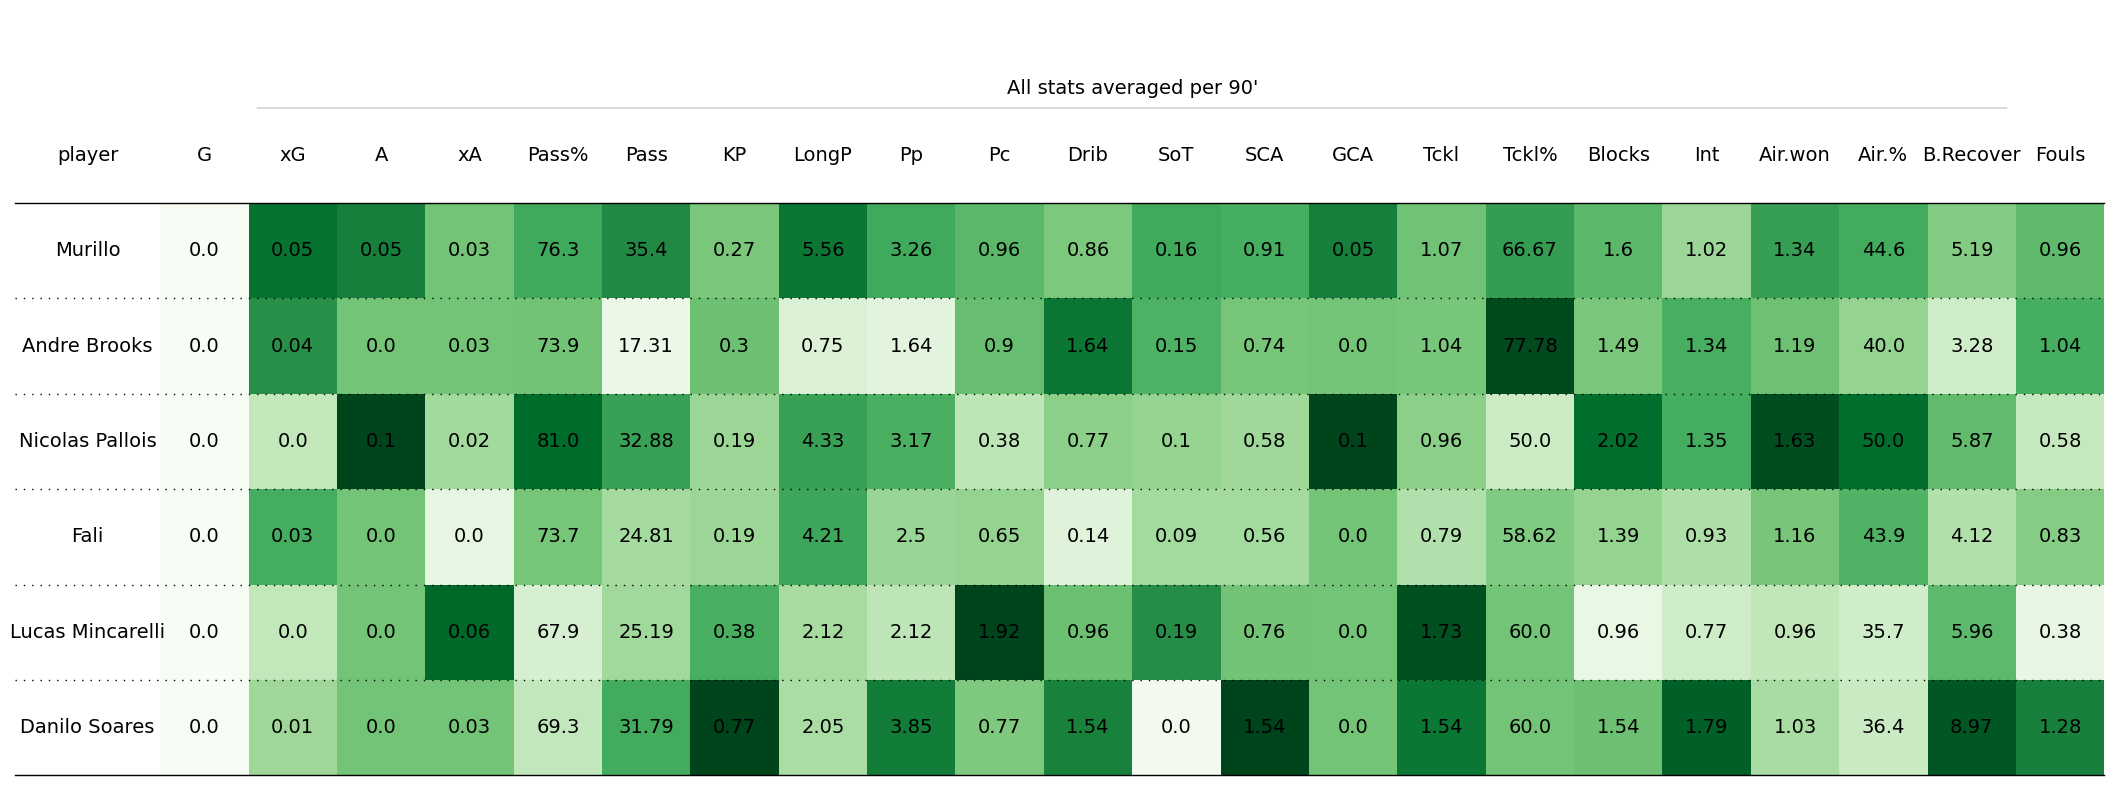

In [ ]:
def main():
    player_name = input("Enter a player name: ")
    n = check_pos(player_name)
    if isinstance(n, tuple):
      pos1, pos2 = check_pos(player_name)
      position = input(f"Player can be compared to two positions ({pos1},{pos2}): ")
      while position not in [f'{pos1}', f'{pos2}']:
          print(f"Invalid position! Please choose from {pos1},{pos2}")
          position = input(f"Player can be compared to two positions ({pos1},{pos2}): ")
    else:
      position = check_pos(player_name)
    test_df = create_test_df(player_name, position,"Big5")          ## Change mode for choosing league Options are "LaLiga" & "Big5"
    test_df.fillna(0, inplace=True)
    test_df
    similar_players, similarity_scores= recommend_similar_players(test_df,player_name)
    similar_players = preprocess_df(similar_players,position)
    make_plottable_table(similar_players)
    #print(similarity_scores)

    new_index = similar_players.index[1:]
    similarity_scores = similarity_scores
    new_df = pd.DataFrame({'similarity_scores': similarity_scores}, index=new_index)
    print(new_df)

if __name__ == "__main__":
    main()